# Next Pitch Prediction using Attention-based LSTMs

The next series of tests will be carried out using Attention-based LSTMs. Attention-based LSTMs implement the attention mechanism to focus on specific parts of the input sequence, which can be beneficial for time series data like pitch prediction.

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf
import keras_tuner

os.chdir('../..')
tf.keras.utils.set_random_seed(42)

The first step is to load the pitch data and sequence it into a format that can be used to train the LSTM. For this, the preprocessing utils developed earlier will be used.

It is also necessary to split the data into training, validation and test sets. A 60-20-20 split will be done using Scikit Learn.

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=54)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

## Develop a model that does better than the baseline

The first step in the process is to develop a basic model that beats the baseline. This model will be a ensemble of LSTMs with 1 hidden layer with 128 units.

To streamline the process, two new functions will be developed:
- `build_network`: which builds a single LSTM network with the specified parameters and compiles it.
- `build_model`: which builds an ensemble of LSTM networks. This function will be used by Keras Tuner to optimize the hyperparameters of the model.

In [3]:
def build_network(input_layer, num_targets, name='', num_hidden_units=256, num_lstm_layers=2, num_dense_layers=2, activation='relu', reg=None, dropout=None):
    # Hidden LSTM layers
    x = input_layer
    for i in range(num_lstm_layers):
        layer_name = f"{name}_hidden_{i+1}"
        if reg:
            x = tf.keras.layers.LSTM(units=num_hidden_units, return_sequences=True, kernel_regularizer=reg, name=layer_name)(x)
        else:
            x = tf.keras.layers.LSTM(units=num_hidden_units, return_sequences=True, name=layer_name)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)
    
    # Attention layer
    attention_output = tf.keras.layers.Attention(name=f"{name}_attention")([x, x])
    
    # Flatten the output
    x = tf.keras.layers.Flatten(name=f"{name}_flatten")(attention_output)
    
    # Dense layers
    for i in range(num_dense_layers):
        x = tf.keras.layers.Dense(32, activation=activation, name=f"{name}_dense_{i+1}")(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs

It is important to define the search space for the hyperparameters. The following hyperparameters will be optimized:

- **Number of units in the hidden layer**: This will be chosen from the values [128, 256, 512].
- **Number of hidden layers**: This will be an integer value between 1 and 3.
- **Number of dense layers**: This will be an integer value between 1 and 3.
- **Activation function**: This will be chosen from the values ['relu', 'elu', 'tanh', 'sigmoid'].
- **Recurrent activation function**: This will be chosen from the values ['relu', 'elu', 'sigmoid', 'tanh'].

In [4]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                         num_lstm_layers=hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1),
                         num_dense_layers=hp.Int('num_dense_layers', min_value=1, max_value=3, step=1),
                         activation=hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid']),
                         reg=None,
                         dropout=None)
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                          num_lstm_layers=hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1),
                          num_dense_layers=hp.Int('num_dense_layers', min_value=1, max_value=3, step=1),
                          activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                          reg=None,
                          dropout=None)
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                            num_lstm_layers=hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1),
                            num_dense_layers=hp.Int('num_dense_layers', min_value=1, max_value=3, step=1),
                            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                            reg=None,
                            dropout=None)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

To avoid wasting time and computational resources, we will implement the FreezeOutputCallback class. This class will be used to freeze specific networks in the ensemble if their validation accuracy is worsening. If all networks in the ensemble are frozen, the training will be stopped.

In [5]:
from utils.callbacks import FreezeOutputCallback

freeze_output_callback = FreezeOutputCallback(patience=5)

In [6]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output vertical at 8 epochs.

Freezing output horizontal at 43 epochs.

Freezing output pitch at 61 epochs.

All outputs frozen. Stopping training at epoch 61.


In [7]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - horizontal_output_accuracy: 0.6724 - loss: 5.1192 - pitch_output_accuracy: 0.6223 - vertical_output_accuracy: 0.6937
Pitch Test Accuracy: 0.6809298992156982
Vertical Test Accuracy: 0.6091644167900085
Horizontal Test Accuracy: 0.6997978687286377


We can notice a considerable improvement in the model performance.

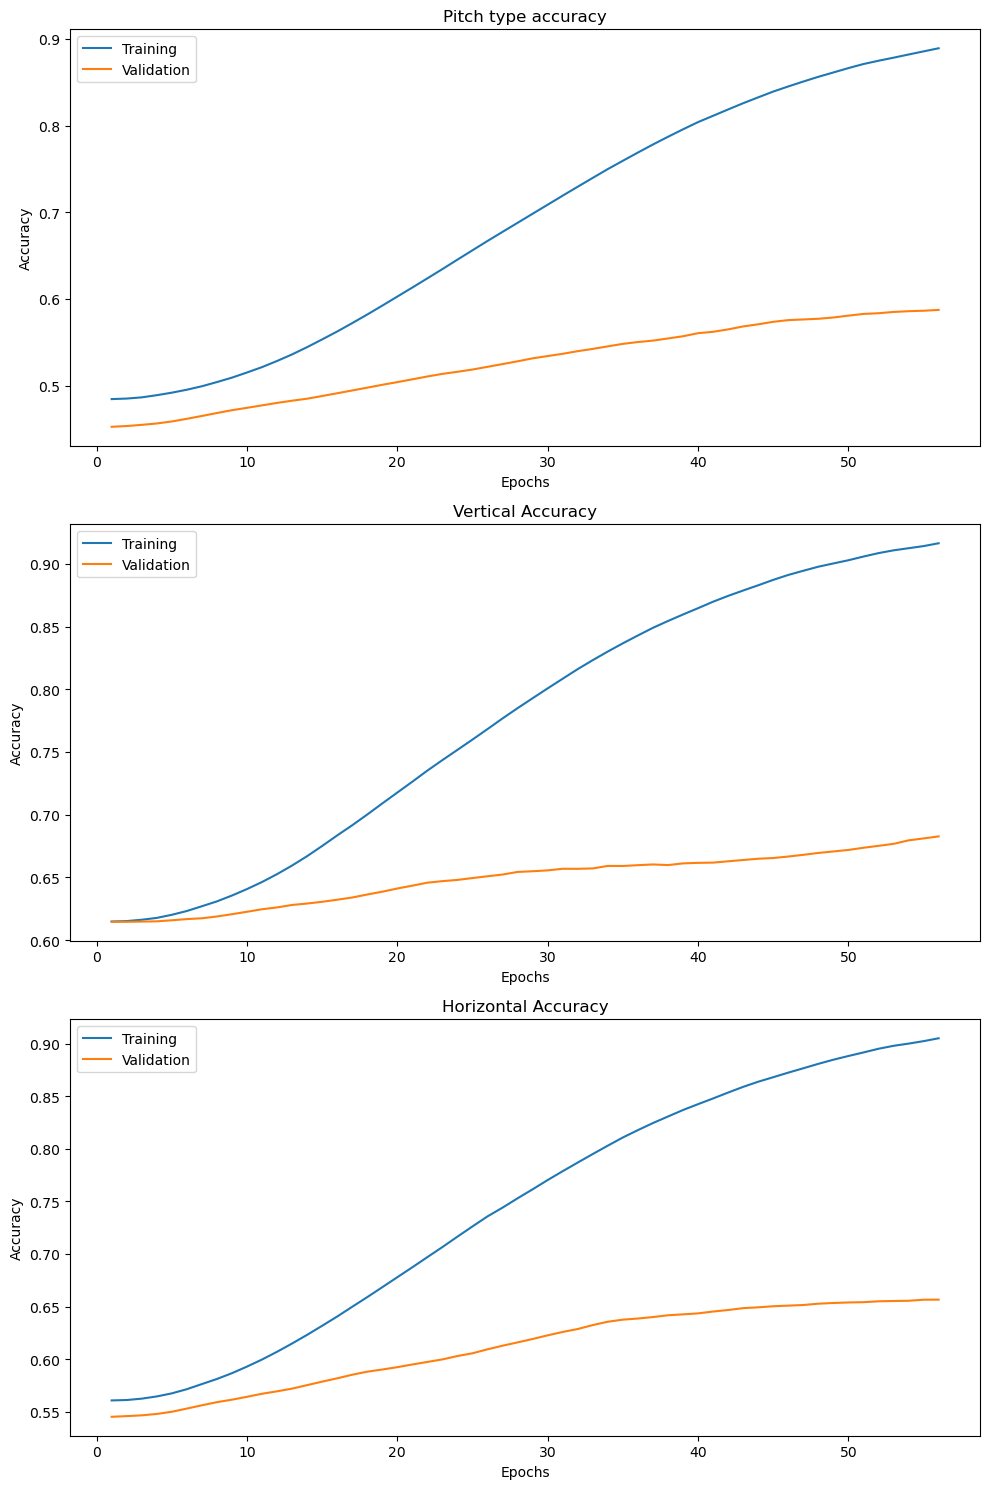

In [8]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

## Scale up

Now, it is time to scale up the model to increase its performance. For this, we will run Bayesian optimization using the `BayesianOptimization` class from the Keras Tuner library. The search space will be the one defined earlier. The optimization will be carried out for 10 iterations.

In [7]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=10,
    project_name='Attention_LSTM_Ensemble'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=100, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

Trial 10 Complete [00h 55m 24s]
multi_objective: -1.8756738305091858

Best multi_objective So Far: -1.9177896976470947
Total elapsed time: 02h 56m 01s


In [9]:
import pandas as pd

# Get the tuner results
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Extract relevant information
results = []
for trial in tuner_results:
    trial_summary = {
        'Trial ID': trial.trial_id,
        'Hidden layers': trial.hyperparameters.values['num_lstm_layers'],
        'Hidden units': trial.hyperparameters.values['num_hidden_units'],
        'Dense layers': trial.hyperparameters.values['num_dense_layers'],
        'Activation': trial.hyperparameters.values['activation'],
        'Score': trial.score,
        'Pitch Accuracy': trial.metrics.get_last_value('val_pitch_output_accuracy'),
        'Vertical Accuracy': trial.metrics.get_last_value('val_vertical_output_accuracy'),
        'Horizontal Accuracy': trial.metrics.get_last_value('val_horizontal_output_accuracy')
    }
    results.append(trial_summary)

# Create a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('lstm_search_results.csv', index=False)

# Display the results
results_df

,Trial ID,Hidden layers,Hidden units,Dense layers,Activation,Score,Pitch Accuracy,Vertical Accuracy,Horizontal Accuracy
0,05,3,128,1,sigmoid,-1.917790,0.594340,0.681941,0.641509
1,03,1,256,1,sigmoid,-1.907682,0.587938,0.673181,0.646563
2,07,1,128,1,sigmoid,-1.896900,0.575809,0.675202,0.645889
3,06,3,128,2,relu,-1.890836,0.586927,0.670822,0.633086
4,01,2,256,2,elu,-1.887129,0.612197,0.631065,0.643868
5,04,1,256,2,tanh,-1.883086,0.584232,0.655997,0.642857
6,09,3,512,2,relu,-1.875674,0.603100,0.664420,0.608154
7,00,3,512,1,tanh,-1.861860,0.592992,0.653302,0.615566
8,02,2,512,3,relu,-1.801887,0.563342,0.635445,0.603100
9,08,2,512,3,sigmoid,-1.596024,0.396226,0.616914,0.582884


We notice that the models with most hidden units performed worse than simpler models. This is probably due to the fact that the models with more hidden units are more prone to overfitting. Notably, models with sigmoid activations had the best performance overall.

Trial 05 was the best performing model and will be used for the next steps.

## Regularizing the model

In [5]:
def build_model():
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_units=128,
                         num_lstm_layers=3,
                         num_dense_layers=1,
                         activation='sigmoid',
                         reg=None,
                         dropout=None)
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_units=128,
                          num_lstm_layers=3,
                          num_dense_layers=1,
                          activation='sigmoid',
                          reg=None,
                          dropout=None)
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_units=128,
                            num_lstm_layers=3,
                            num_dense_layers=1,
                            activation='sigmoid',
                            reg=None,
                            dropout=None)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [9]:
freeze_output_callback = FreezeOutputCallback(patience=10)

model = build_model()
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=1
                            )

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - horizontal_output_accuracy: 0.4381 - loss: 3.5207 - pitch_output_accuracy: 0.3315 - vertical_output_accuracy: 0.5664 - val_horizontal_output_accuracy: 0.5253 - val_loss: 3.2847 - val_pitch_output_accuracy: 0.3962 - val_vertical_output_accuracy: 0.6169
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - horizontal_output_accuracy: 0.5265 - loss: 3.2980 - pitch_output_accuracy: 0.4071 - vertical_output_accuracy: 0.6094 - val_horizontal_output_accuracy: 0.5384 - val_loss: 3.2678 - val_pitch_output_accuracy: 0.3962 - val_vertical_output_accuracy: 0.6169
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - horizontal_output_accuracy: 0.5343 - loss: 3.2758 - pitch_output_accuracy: 0.4071 - vertical_output_accuracy: 0.6103 - val_horizontal_output_accuracy: 0.5421 - val_loss: 3.2643 - val_pitch_output_accuracy: 0.3962 - val_vertical_output_accuracy: 0.6176
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - horizontal_output_a

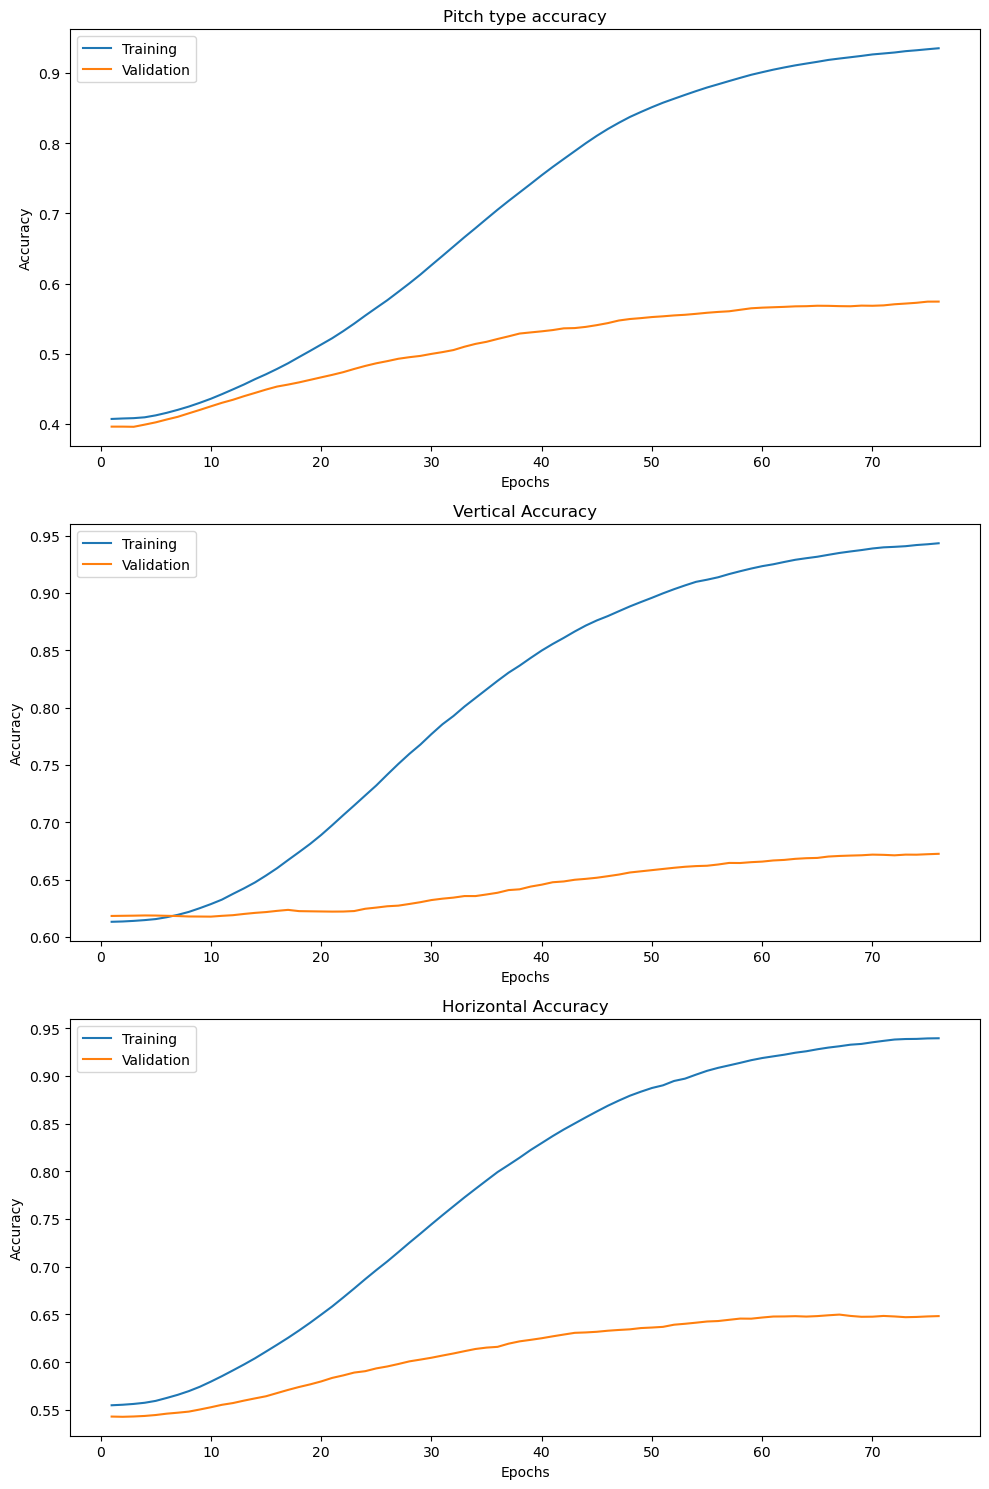

In [11]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

We see no signs of overfitting in any of the networks. In fact, the validation accuracy gets stalled at around 0.6 for all outputs. We will try to regularize the model to see if we can improve the performance.

### Regularization

In [12]:
def build_model(reg = None, drop = None):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_units=128,
                         num_lstm_layers=3,
                         num_dense_layers=1,
                         activation='sigmoid',
                         reg=reg,
                         dropout=drop)
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_units=128,
                          num_lstm_layers=3,
                          num_dense_layers=1,
                          activation='sigmoid',
                          reg=reg,
                          dropout=drop)
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_units=128,
                            num_lstm_layers=3,
                            num_dense_layers=1,
                            activation='sigmoid',
                            reg=reg,
                            dropout=drop)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [ ]:
freeze_output_callback = FreezeOutputCallback(patience=10)

regularizations = [tf.keras.regularizers.l1(0.001), tf.keras.regularizers.l2(0.001), tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)]
histories = []

for reg in regularizations:
    print("Testing with regularization:", reg)
    model = build_model(reg=reg)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories.append(history)

Testing with regularization: <keras.src.regularizers.regularizers.L1 object at 0x000001DF78CBF3D0>

Freezing output vertical at 11 epochs.

Freezing output horizontal at 11 epochs.

Freezing output pitch at 35 epochs.

All outputs frozen. Stopping training at epoch 35.
Testing with regularization: <keras.src.regularizers.regularizers.L2 object at 0x000001DF78C3A9D0>

Freezing output vertical at 11 epochs.

Freezing output horizontal at 63 epochs.

Freezing output pitch at 66 epochs.

All outputs frozen. Stopping training at epoch 66.
Testing with regularization: <keras.src.regularizers.regularizers.L1L2 object at 0x000001DF78C3AA50>

Freezing output vertical at 11 epochs.

Freezing output horizontal at 11 epochs.

Freezing output pitch at 35 epochs.

All outputs frozen. Stopping training at epoch 35.


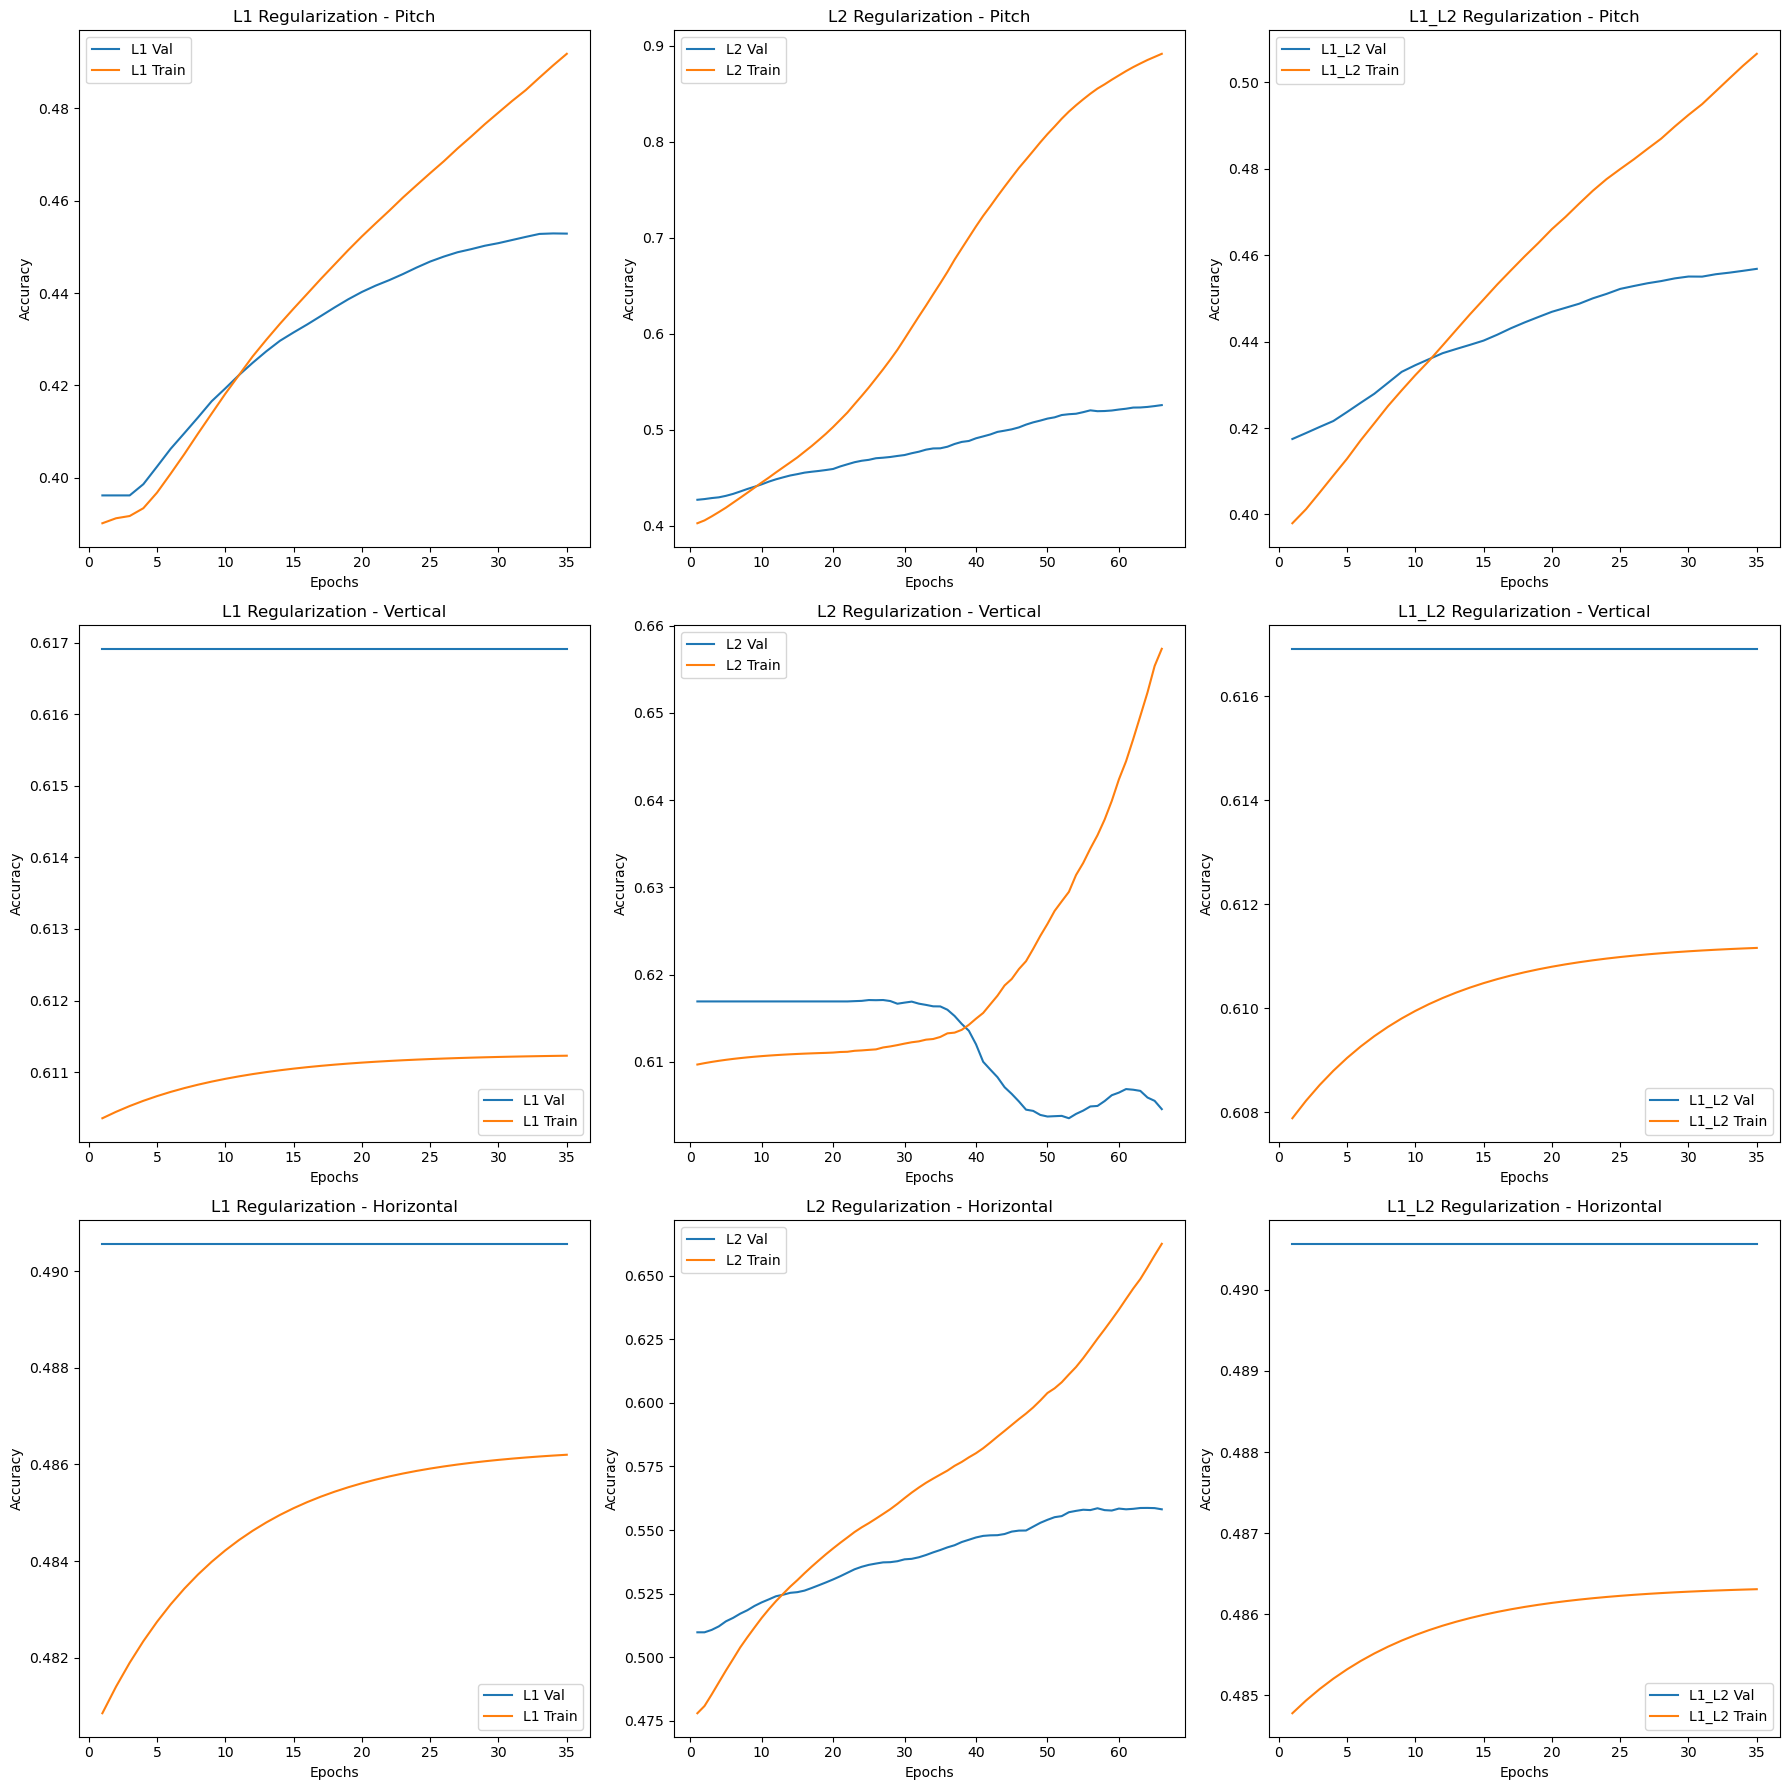

In [15]:
from utils.plot_utils import smooth_curve

import matplotlib.pyplot as plt

# Smooth the curves for better visualization
smooth_l1_pitch_val = smooth_curve(histories[0].history['val_pitch_output_accuracy'])
smooth_l2_pitch_val = smooth_curve(histories[1].history['val_pitch_output_accuracy'])
smooth_l1_l2_pitch_val = smooth_curve(histories[2].history['val_pitch_output_accuracy'])

smooth_l1_pitch_train = smooth_curve(histories[0].history['pitch_output_accuracy'])
smooth_l2_pitch_train = smooth_curve(histories[1].history['pitch_output_accuracy'])
smooth_l1_l2_pitch_train = smooth_curve(histories[2].history['pitch_output_accuracy'])

smooth_l1_vertical_val = smooth_curve(histories[0].history['val_vertical_output_accuracy'])
smooth_l2_vertical_val = smooth_curve(histories[1].history['val_vertical_output_accuracy'])
smooth_l1_l2_vertical_val = smooth_curve(histories[2].history['val_vertical_output_accuracy'])

smooth_l1_vertical_train = smooth_curve(histories[0].history['vertical_output_accuracy'])
smooth_l2_vertical_train = smooth_curve(histories[1].history['vertical_output_accuracy'])
smooth_l1_l2_vertical_train = smooth_curve(histories[2].history['vertical_output_accuracy'])

smooth_l1_horizontal_val = smooth_curve(histories[0].history['val_horizontal_output_accuracy'])
smooth_l2_horizontal_val = smooth_curve(histories[1].history['val_horizontal_output_accuracy'])
smooth_l1_l2_horizontal_val = smooth_curve(histories[2].history['val_horizontal_output_accuracy'])

smooth_l1_horizontal_train = smooth_curve(histories[0].history['horizontal_output_accuracy'])
smooth_l2_horizontal_train = smooth_curve(histories[1].history['horizontal_output_accuracy'])
smooth_l1_l2_horizontal_train = smooth_curve(histories[2].history['horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot L1 regularization
axes[0, 0].plot(range(1, len(smooth_l1_pitch_val) + 1), smooth_l1_pitch_val, label='L1 Val')
axes[0, 0].plot(range(1, len(smooth_l1_pitch_train) + 1), smooth_l1_pitch_train, label='L1 Train')
axes[0, 0].set_title('L1 Regularization - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

axes[1, 0].plot(range(1, len(smooth_l1_vertical_val) + 1), smooth_l1_vertical_val, label='L1 Val')
axes[1, 0].plot(range(1, len(smooth_l1_vertical_train) + 1), smooth_l1_vertical_train, label='L1 Train')
axes[1, 0].set_title('L1 Regularization - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

axes[2, 0].plot(range(1, len(smooth_l1_horizontal_val) + 1), smooth_l1_horizontal_val, label='L1 Val')
axes[2, 0].plot(range(1, len(smooth_l1_horizontal_train) + 1), smooth_l1_horizontal_train, label='L1 Train')
axes[2, 0].set_title('L1 Regularization - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot L2 regularization
axes[0, 1].plot(range(1, len(smooth_l2_pitch_val) + 1), smooth_l2_pitch_val, label='L2 Val')
axes[0, 1].plot(range(1, len(smooth_l2_pitch_train) + 1), smooth_l2_pitch_train, label='L2 Train')
axes[0, 1].set_title('L2 Regularization - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 1].plot(range(1, len(smooth_l2_vertical_val) + 1), smooth_l2_vertical_val, label='L2 Val')
axes[1, 1].plot(range(1, len(smooth_l2_vertical_train) + 1), smooth_l2_vertical_train, label='L2 Train')
axes[1, 1].set_title('L2 Regularization - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

axes[2, 1].plot(range(1, len(smooth_l2_horizontal_val) + 1), smooth_l2_horizontal_val, label='L2 Val')
axes[2, 1].plot(range(1, len(smooth_l2_horizontal_train) + 1), smooth_l2_horizontal_train, label='L2 Train')
axes[2, 1].set_title('L2 Regularization - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

# Plot L1_L2 regularization
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch_val) + 1), smooth_l1_l2_pitch_val, label='L1_L2 Val')
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch_train) + 1), smooth_l1_l2_pitch_train, label='L1_L2 Train')
axes[0, 2].set_title('L1_L2 Regularization - Pitch')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()

axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical_val) + 1), smooth_l1_l2_vertical_val, label='L1_L2 Val')
axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical_train) + 1), smooth_l1_l2_vertical_train, label='L1_L2 Train')
axes[1, 2].set_title('L1_L2 Regularization - Vertical')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].legend()

axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal_val) + 1), smooth_l1_l2_horizontal_val, label='L1_L2 Val')
axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal_train) + 1), smooth_l1_l2_horizontal_train, label='L1_L2 Train')
axes[2, 2].set_title('L1_L2 Regularization - Horizontal')
axes[2, 2].set_xlabel('Epochs')
axes[2, 2].set_ylabel('Accuracy')
axes[2, 2].legend()

plt.tight_layout()
plt.show()

We don't see any improvement in the model performance after applying regularization. We will stick to the model with the best performance so far.

### Dropout

In [13]:
dropout_rates = [0, 0.5]
histories_dropout = []

for dropout_rate in dropout_rates:
    print("Testing with dropout rate:", dropout_rate)
    model = build_model(drop=dropout_rate)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories_dropout.append(history)

Testing with dropout rate: 0

Freezing output pitch at 11 epochs.

Freezing output vertical at 19 epochs.

Freezing output horizontal at 53 epochs.

All outputs frozen. Stopping training at epoch 53.
Testing with dropout rate: 0.5

Freezing output vertical at 60 epochs.

Freezing output horizontal at 62 epochs.


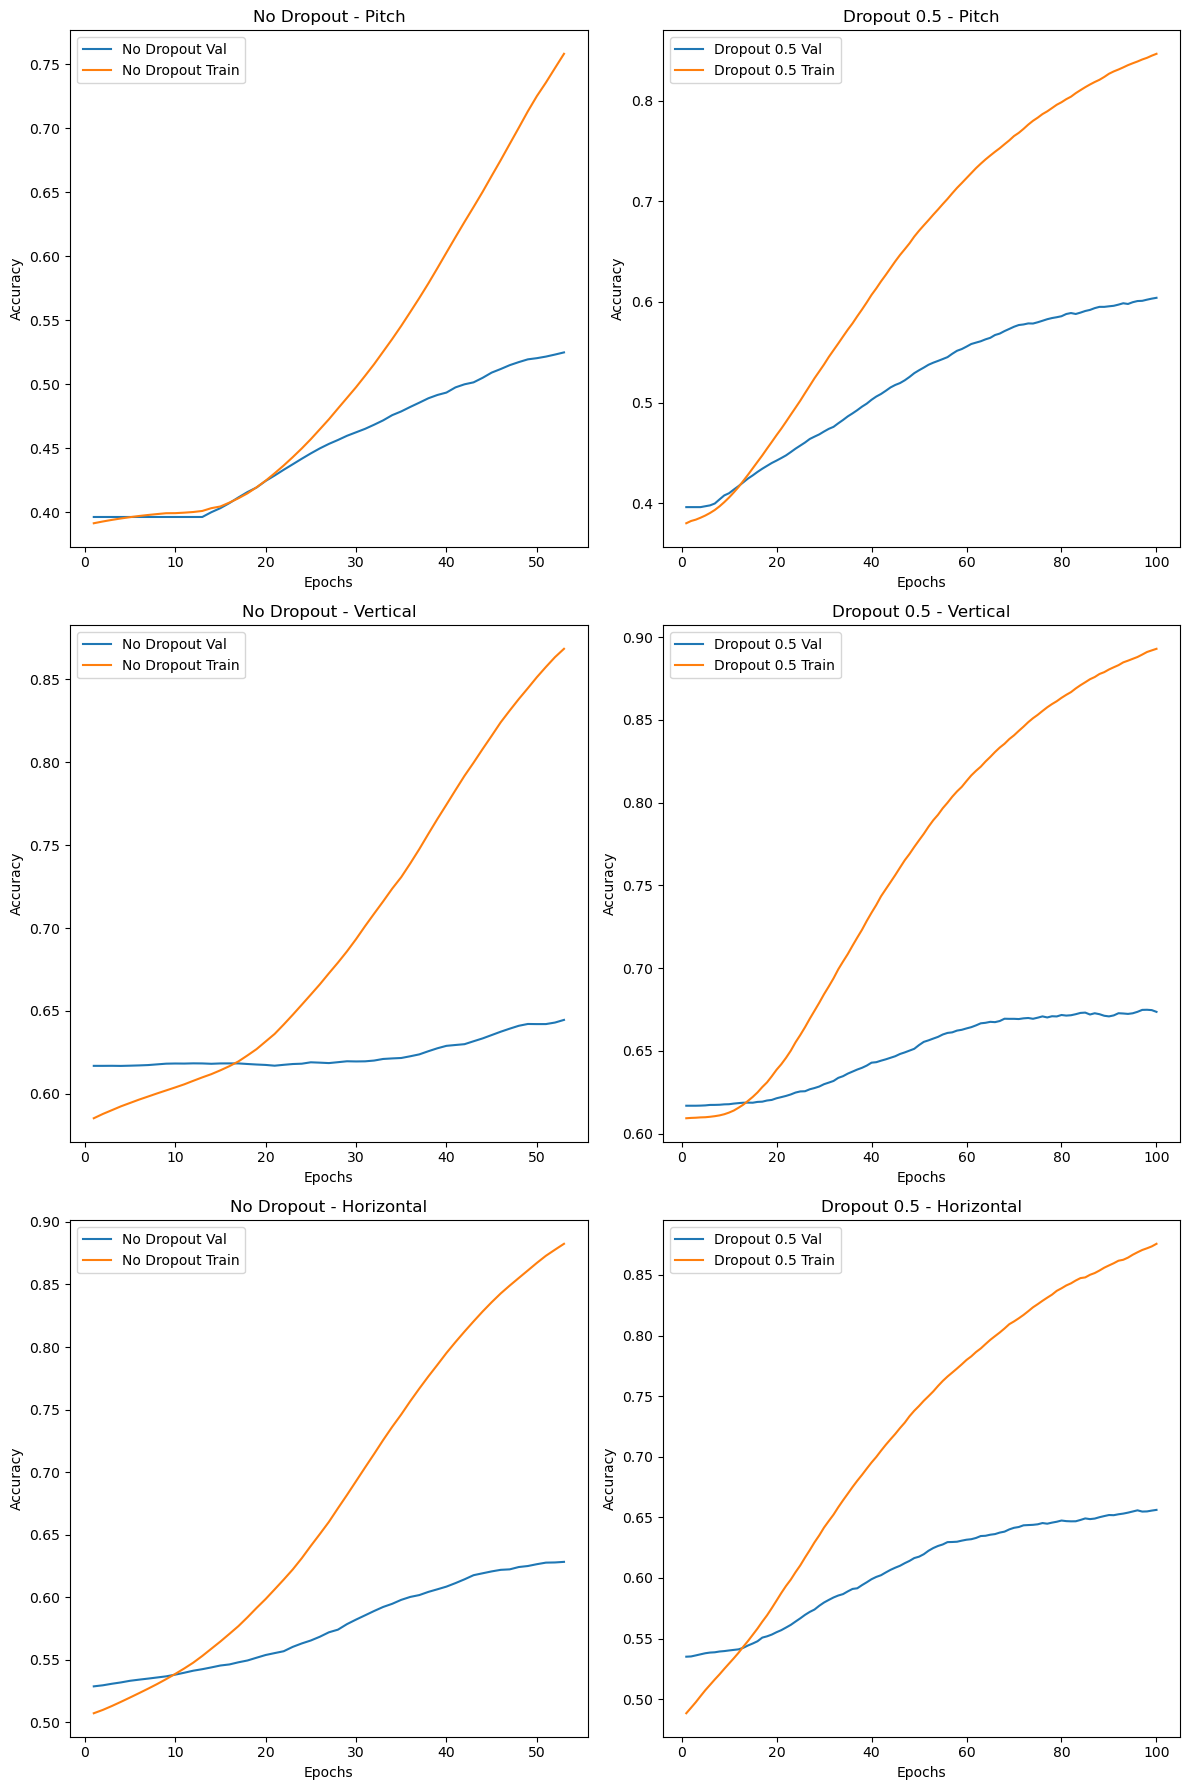

In [16]:
# Smooth the curves for better visualization
smooth_no_drop_pitch_val = smooth_curve(histories_dropout[0].history['val_pitch_output_accuracy'])
smooth_drop_05_pitch_val = smooth_curve(histories_dropout[1].history['val_pitch_output_accuracy'])
smooth_no_drop_pitch_train = smooth_curve(histories_dropout[0].history['pitch_output_accuracy'])
smooth_drop_05_pitch_train = smooth_curve(histories_dropout[1].history['pitch_output_accuracy'])

smooth_no_drop_vertical_val = smooth_curve(histories_dropout[0].history['val_vertical_output_accuracy'])
smooth_drop_05_vertical_val = smooth_curve(histories_dropout[1].history['val_vertical_output_accuracy'])
smooth_no_drop_vertical_train = smooth_curve(histories_dropout[0].history['vertical_output_accuracy'])
smooth_drop_05_vertical_train = smooth_curve(histories_dropout[1].history['vertical_output_accuracy'])

smooth_no_drop_horizontal_val = smooth_curve(histories_dropout[0].history['val_horizontal_output_accuracy'])
smooth_drop_05_horizontal_val = smooth_curve(histories_dropout[1].history['val_horizontal_output_accuracy'])
smooth_no_drop_horizontal_train = smooth_curve(histories_dropout[0].history['horizontal_output_accuracy'])
smooth_drop_05_horizontal_train = smooth_curve(histories_dropout[1].history['horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Plot without dropout for pitch
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch_val) + 1), smooth_no_drop_pitch_val, label='No Dropout Val')
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch_train) + 1), smooth_no_drop_pitch_train, label='No Dropout Train')
axes[0, 0].set_title('No Dropout - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot with 0.5 dropout for pitch
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch_val) + 1), smooth_drop_05_pitch_val, label='Dropout 0.5 Val')
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch_train) + 1), smooth_drop_05_pitch_train, label='Dropout 0.5 Train')
axes[0, 1].set_title('Dropout 0.5 - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot without dropout for vertical
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical_val) + 1), smooth_no_drop_vertical_val, label='No Dropout Val')
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical_train) + 1), smooth_no_drop_vertical_train, label='No Dropout Train')
axes[1, 0].set_title('No Dropout - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot with 0.5 dropout for vertical
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical_val) + 1), smooth_drop_05_vertical_val, label='Dropout 0.5 Val')
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical_train) + 1), smooth_drop_05_vertical_train, label='Dropout 0.5 Train')
axes[1, 1].set_title('Dropout 0.5 - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Plot without dropout for horizontal
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal_val) + 1), smooth_no_drop_horizontal_val, label='No Dropout Val')
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal_train) + 1), smooth_no_drop_horizontal_train, label='No Dropout Train')
axes[2, 0].set_title('No Dropout - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot with 0.5 dropout for horizontal
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal_val) + 1), smooth_drop_05_horizontal_val, label='Dropout 0.5 Val')
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal_train) + 1), smooth_drop_05_horizontal_train, label='Dropout 0.5 Train')
axes[2, 1].set_title('Dropout 0.5 - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


We see that the model with dropout has a better performance than the model without it.

## Final Model

Dropout will be used for all networks. The best hyperparameters for each output will be used to build the final model.

In [22]:
def build_model():
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

    drop = 0.5
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_units=128,
                         num_lstm_layers=3,
                         num_dense_layers=1,
                         activation='sigmoid',
                         dropout=drop)
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_units=128,
                          num_lstm_layers=3,
                          num_dense_layers=1,
                          activation='sigmoid',
                          dropout=drop)
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_units=128,
                            num_lstm_layers=3,
                            num_dense_layers=1,
                            activation='sigmoid',
                            dropout=drop)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [23]:
# Test the build_model function
model = build_model()

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output horizontal at 57 epochs.


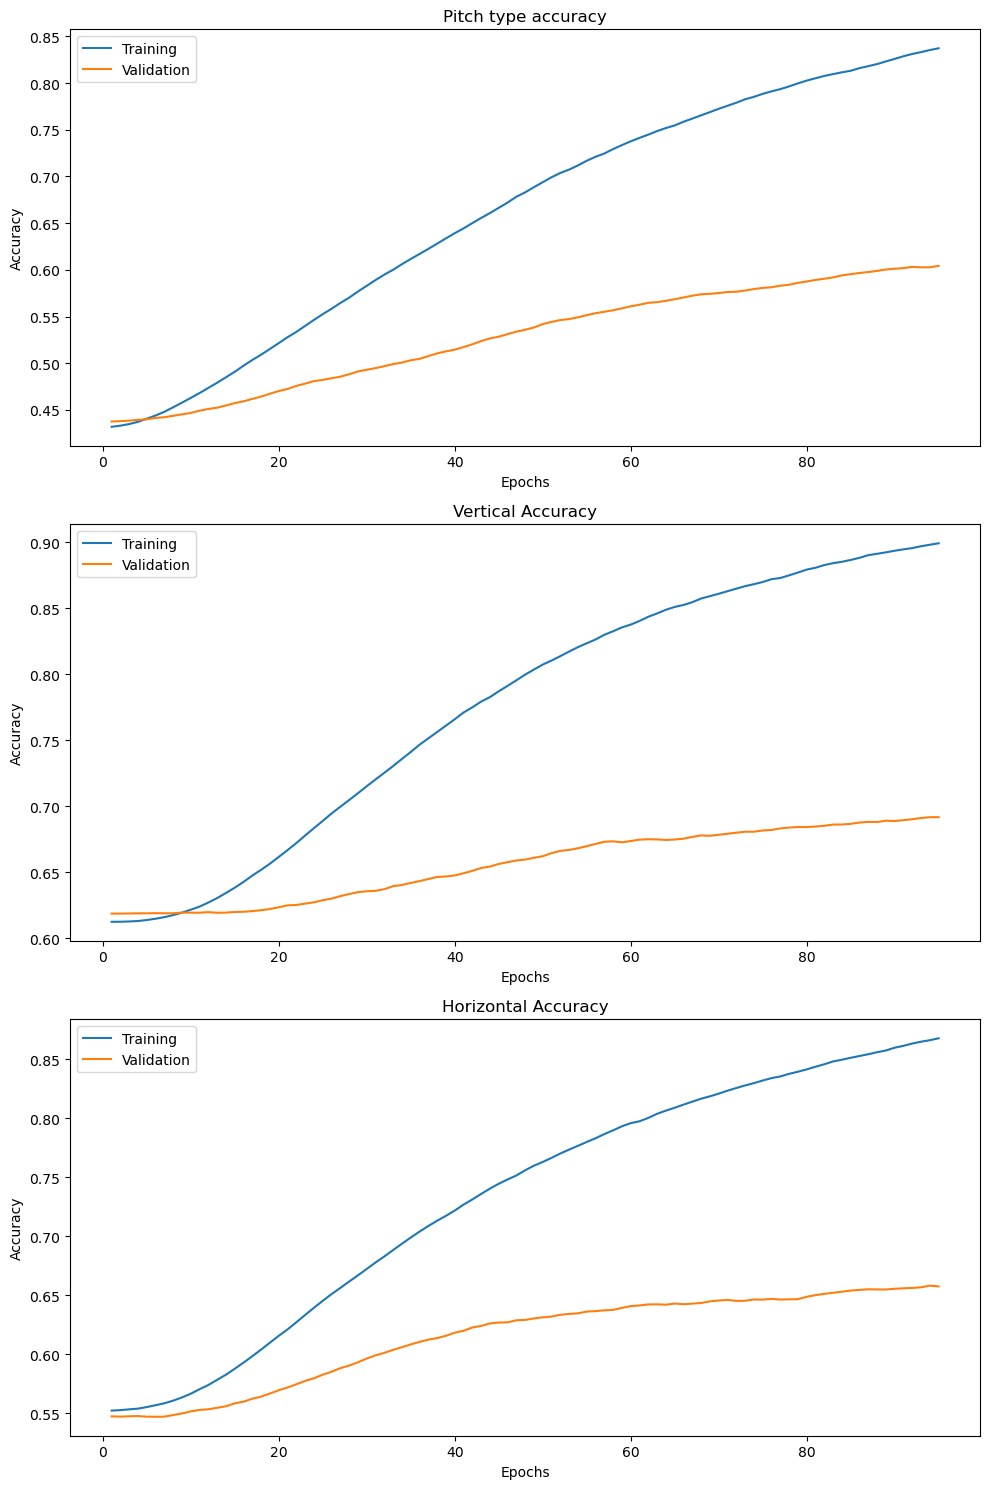

In [24]:
from utils.plot_utils import plot_ensemble_history
plot_ensemble_history(history)

In [25]:
max_pitch_val_accuracy = max(history.history['val_pitch_output_accuracy'])
max_vertical_val_accuracy = max(history.history['val_vertical_output_accuracy'])
max_horizontal_val_accuracy = max(history.history['val_horizontal_output_accuracy'])

print(f"Max Pitch Validation Accuracy: {max_pitch_val_accuracy}")
print(f"Max Vertical Validation Accuracy: {max_vertical_val_accuracy}")
print(f"Max Horizontal Validation Accuracy: {max_horizontal_val_accuracy}")

Max Pitch Validation Accuracy: 0.6179245114326477
Max Vertical Validation Accuracy: 0.6991239786148071
Max Horizontal Validation Accuracy: 0.671159029006958


We can see a considerable increase in each output's accuracy compared to the baseline. Now, it is time to test the final model in the test set.

In [26]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - horizontal_output_accuracy: 0.6885 - loss: 3.7867 - pitch_output_accuracy: 0.6192 - vertical_output_accuracy: 0.6843
Pitch Test Accuracy: 0.6812668442726135
Vertical Test Accuracy: 0.6290431022644043
Horizontal Test Accuracy: 0.6863207817077637


We notice that the model performs well in the test set. The accuracy is around 0.6 for all outputs. This is a considerable improvement compared to the baseline.